In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import math
import datetime as dt
from datetime import datetime
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sodapy import Socrata
import warnings
warnings.filterwarnings("ignore")

# Machine learning libraries
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


# Investigate overall data

In [2]:
# Import data from API
client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')
# To begin, download all data but limit to only for monday noons to get an overview
results = client.get("b2ak-trbp", day='Monday', time=12, limit=50000)
dfraw0 = pd.DataFrame.from_records(results)
display(dfraw0.shape)
display(dfraw0.head())

(18050, 10)

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2891212,2019-11-04T12:00:00.000,2019,November,4,Monday,12,4,Town Hall (West),4535
1,2891213,2019-11-04T12:00:00.000,2019,November,4,Monday,12,17,Collins Place (South),1145
2,2891214,2019-11-04T12:00:00.000,2019,November,4,Monday,12,18,Collins Place (North),421
3,2891215,2019-11-04T12:00:00.000,2019,November,4,Monday,12,53,Collins St (North),2570
4,2891216,2019-11-04T12:00:00.000,2019,November,4,Monday,12,2,Bourke Street Mall (South),5227


In [3]:
# First round of cleaning
df = dfraw0.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

id                       object
date_time        datetime64[ns]
year                      int64
month                    object
mdate                    object
day                      object
time                     object
sensor_id                 int64
sensor_name              object
hourly_counts             int64
date                     object
sensor                   object
dtype: object

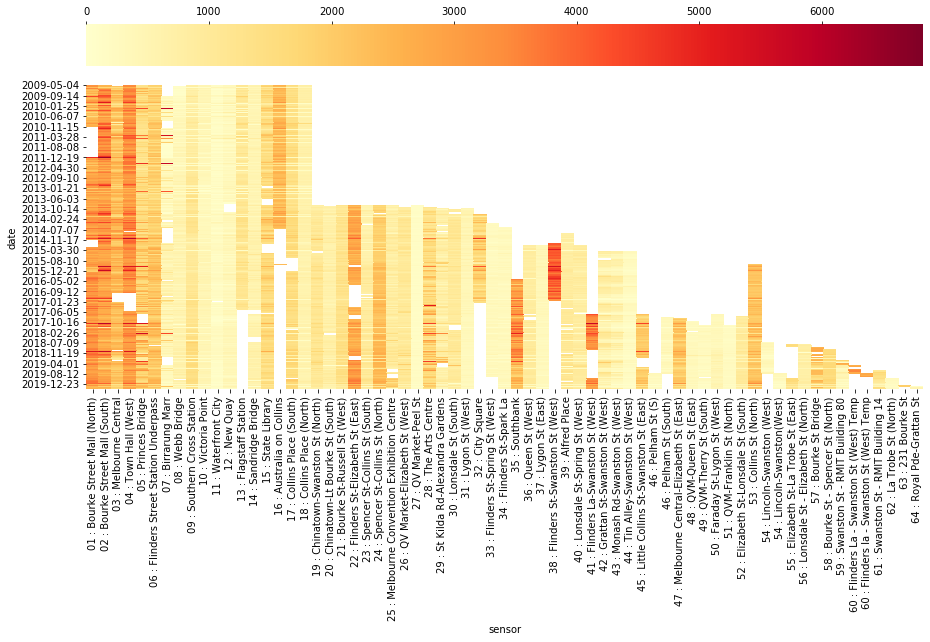

In [4]:
# Convert to pivot for plotting
table = pd.pivot_table(df, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

# Plot all available data, sampling at Monday noon only
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.heatmap(table, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

# Shortlist sensor locations and period

In [5]:
# Group sensor locations based on availability of data

sensor_master = pd.read_excel('files/CBD_grid.xlsx', sheet_name='master')
sensor_master = sensor_master.iloc[:,:6]
sensor_master.head()

,sensor_id,sensor_description,installation_date,CBD,Train_data,Test_data
0,1,Bourke Street Mall (North),2009-03-24,1,1,1
1,2,Bourke Street Mall (South),2009-03-30,1,1,1
2,3,Melbourne Central,2009-03-25,1,1,1
3,4,Town Hall (West),2009-03-23,1,1,1
4,5,Princes Bridge,2009-03-26,1,1,1


In [6]:
# List of sensor for training and test data
sensors = list(sensor_master[sensor_master['CBD']==1].sensor_id)
sensors_train_test = list(sensor_master[sensor_master['Train_data']==1].sensor_id)
sensors_test = list(sensor_master[(sensor_master['Train_data']==0)&sensor_master['Test_data']==1].sensor_id)
len(sensors)

36

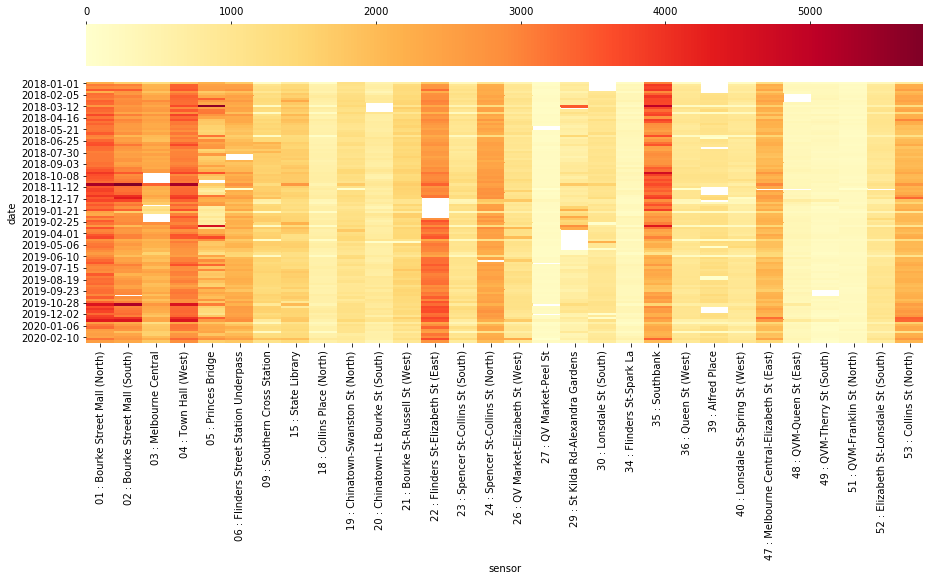

In [7]:
# Visualize training+test sensors for past 2 years
dftt = df[df['sensor_id'].isin(sensors_train_test)]
dfplot2 = dftt[dftt['year'] >= 2018][['date','sensor','hourly_counts']]

table2 = pd.pivot_table(dfplot2, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(15,6))
ax = sns.heatmap(table2, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

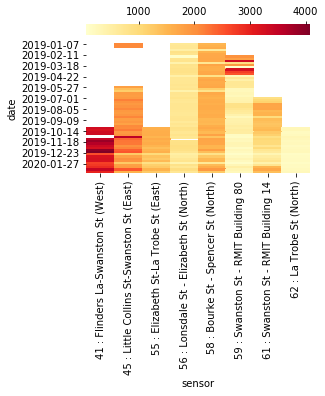

In [8]:
# Visualize test sensors only
dfts = df[df['sensor_id'].isin(sensors_test)]
table3 = pd.pivot_table(dfts[dfts['year'] >= 2019], values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(table3, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

In [9]:
# Download all data for shortlisted sensor for last 2 years

# pbar  = progressbar.ProgressBar()
# dfraw = pd.DataFrame(columns=dfraw0.columns)
# years = [2018, 2019, 2020]

# for year in years:
#     for sensor in sensors:
#         results = client.get("b2ak-trbp", sensor_id=sensor, year=year, limit=10000)
#         dfitem = pd.DataFrame.from_records(results)
#         dfraw = pd.concat([dfraw, dfitem])
# dfraw.to_csv('files/sensors_data.csv')
# len(dfraw)

In [10]:
# Open from saved API
dfraw = pd.read_csv('files/sensors_data.csv')
dfraw = dfraw.drop('Unnamed: 0', axis=1)

In [11]:
# Check if no missing datastamps 
a = len(dfraw.date_time.unique())
b = 2*365*24 + 31*24 # num of hours from 01-01-2018 to 31-01-2020
c = sorted(dfraw.date_time.unique())[-1]
print('Latest available timestamp in data: {c}'.format(c=c))
print('Number of unique timestamps in data: {a}'.format(a=a))
print('Number of expected timestamps: {b}'.format(b=b))
print('Missing timestamps: {d}'.format(d=b-a))

Latest available timestamp in data: 2020-01-31T23:00:00.000
Number of unique timestamps in data: 18264
Number of expected timestamps: 18264
Missing timestamps: 0


# Deal with missing (null) records

In [12]:
# Reshape df into pivot for filling nulls
df0 = dfraw[dfraw['sensor_id'].isin(sensors_train_test)] # exclude test-only sites
df0 = pd.pivot_table(df0, columns='sensor_id',
                     values='hourly_counts',
                     index=['date_time'],
                     aggfunc=np.sum)
display(df0.shape)

(18264, 30)

In [13]:
# Check the extent of nan values.
# Total records per sensor_id = 18,284
df0.isna().sum()

sensor_id
1      144
2      240
3     1570
4        0
5      264
6      433
9        0
15       0
18       0
19       0
20     792
21       0
22    1512
23       0
24      72
26      48
27     672
29    1634
30     600
34       0
35       0
36       0
39    2286
40       0
47     108
48     708
49     408
51       0
52     121
53       0
dtype: int64

In [14]:
# Since hourly traffic is very cyclical, copy value from the same time and the same day a week ago.

# Number of hours in a week
week_hrs = 7*24

for site in df0.columns:
    for row in range(len(df0.index)):
      # check if hourly record is null
        if math.isnan(df0[site].iloc[row]):
          # if so, copy from the same hour from a week ago
            if row - week_hrs > 0:
                df0[site].iloc[row] = df0[site].iloc[row - week_hrs]
            else:
                # if missing at start of the record:
                df0[site].iloc[row] = df0[site].iloc[row + week_hrs*6]

In [15]:
# Double check no nulls left
(df0.isna().sum()).sum()

0

In [16]:
# Unstack pivot to double check and prepare to build other columns

df0 = pd.DataFrame(df0.stack())
df0 = df0.rename(columns={0:'hourly_counts'})
df0 = df0.reset_index()
print('Number of complete timestamps: {b}'.format(b=b))
print('Number of df rows: {l1}'.format(l1=len(df0)))
print('Number df rows / timestamps = num of sites: {l2}'.format(l2=len(df0)/b))

Number of complete timestamps: 18264
Number of df rows: 547920
Number df rows / timestamps = num of sites: 30.0


In [17]:
# Build complete data frame
df = df0.copy()
df['date_time'] = pd.to_datetime(df['date_time']) # format='%Y-%m-%d %H:%M:%S'
df['time']      = df['date_time'].dt.hour
df['mdate']     = df['date_time'].dt.day
df['day']       = df['date_time'].dt.dayofweek
df['week']      = df['date_time'].dt.weekofyear
df['month']     = df['date_time'].dt.month
df['year']      = df['date_time'].dt.year
df['hourly_counts'] = df['hourly_counts'].astype('int')

names_table = sensor_master[['sensor_id', 'sensor_description']].set_index('sensor_id')
names_table = names_table.rename(columns={'sensor_description':'sensor_name'})
df = df.join(names_table, on='sensor_id')
df['sensor'] = (df['sensor_id'].map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + df['sensor_name']
display(len(df))
display(sorted(df.date_time.unique())[-1])
display(df.head(3))
display(df.dtypes)

547920

numpy.datetime64('2020-01-31T23:00:00.000000000')

,date_time,sensor_id,hourly_counts,time,mdate,day,week,month,year,sensor_name,sensor
0,2018-01-01,1,895,0,1,0,1,1,2018,Bourke Street Mall (North),01 : Bourke Street Mall (North)
1,2018-01-01,2,734,0,1,0,1,1,2018,Bourke Street Mall (South),02 : Bourke Street Mall (South)
2,2018-01-01,3,2996,0,1,0,1,1,2018,Melbourne Central,03 : Melbourne Central


date_time        datetime64[ns]
sensor_id                 int64
hourly_counts             int64
time                      int64
mdate                     int64
day                       int64
week                      int64
month                     int64
year                      int64
sensor_name              object
sensor                   object
dtype: object

# Investigate variations by location

## 1. Variation by traffic volume

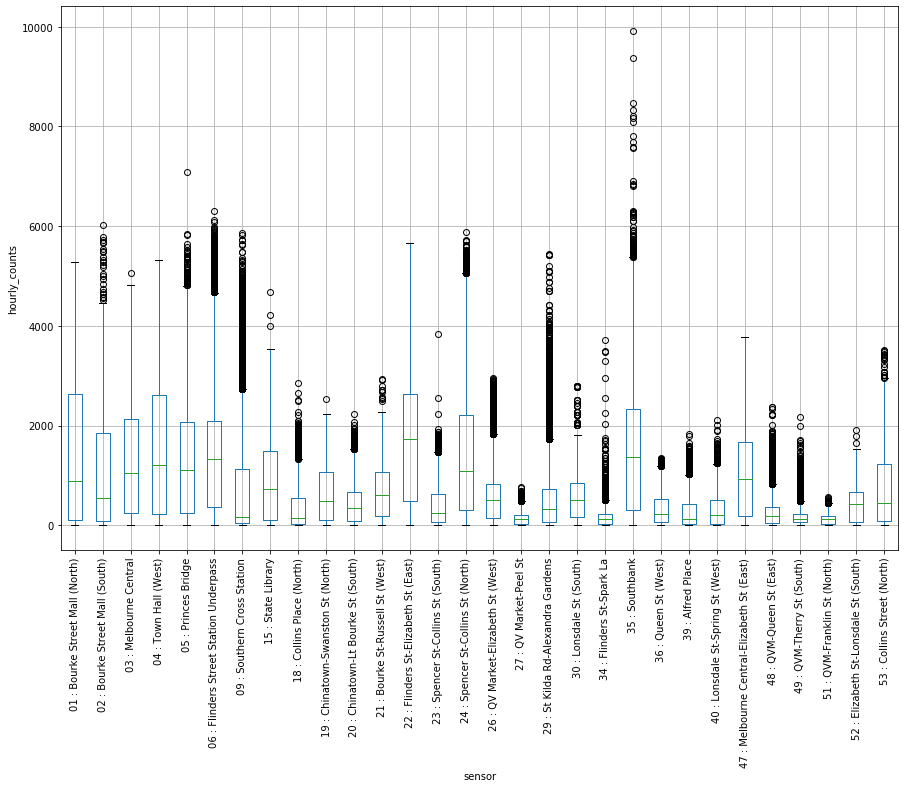

In [18]:
pivotvolume = pd.pivot_table(df, values='hourly_counts',
                             index='date_time', columns='sensor',
                             aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(15,10))
pivotvolume.boxplot(ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('sensor')
ax.set_ylabel('hourly_counts')
plt.show()

## 2. Variation by period: hours, days, weeks

In [19]:
# Prepare data for variation by hour of the day (total)
pivothour = pd.pivot_table(df, values='hourly_counts', columns='day',
                           index='time', aggfunc=np.nanmean)
pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
dfdays = pd.DataFrame(pivothour, index=range(0,24), columns=range(0,7))

# Prepare data for variation by hour of the day (weekday vs weekend)
weekdays = df[df['day'] < 5]
weekends = df[df['day'] > 4]
plot_data = []
for period in ['hours', 'days', 'week']:
    for total in [0,1]:
        cols_pivot = ['sensor_id'] if total==0 else None
        if period=='hours':
            for days in [1,0]:
                data = weekdays if days==1 else weekends
                pivothour  = pd.pivot_table(data, values='hourly_counts',
                                            index='time', columns=cols_pivot,
                                            aggfunc=np.nanmean)
                cols_hour = pivothour.columns
                pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
                dfhour = pd.DataFrame(pivothour, index=range(0,24), columns=cols_hour)
                plot_data.append(dfhour)
        else:
            index_pivot = 'day' if period=='days' else 'week'
            index_df = range(0,7) if period=='days' else range(0,52)

            pivotweek = pd.pivot_table(df, values='hourly_counts',
                                       index=index_pivot, columns=cols_pivot,
                                       aggfunc=np.nanmean)
            cols_week = pivotweek.columns if total==0 else None
            pivotweek = preprocessing.normalize(pivotweek, norm='l1', axis=0)
            dfweek = pd.DataFrame(pivotweek, index=index_df, columns=cols_week)
            plot_data.append(dfweek)

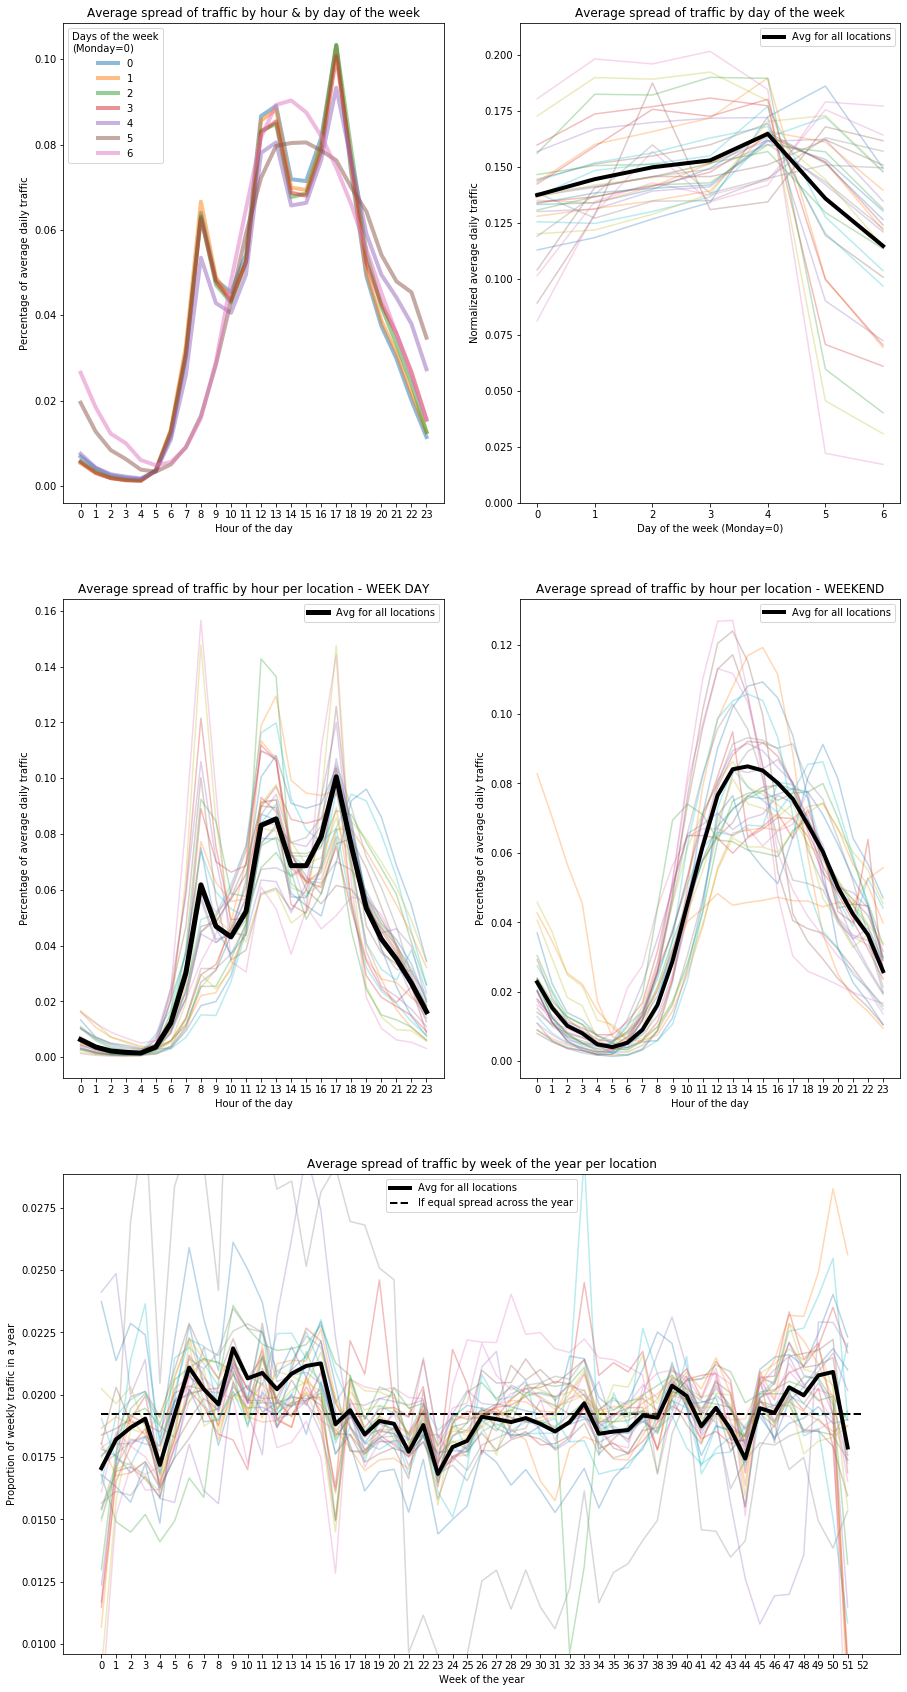

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,30))

ax[0,0].plot(dfdays, linewidth=4, alpha=0.5)
ax[0,0].set_title('Average spread of traffic by hour & by day of the week')
ax[0,0].set_ylabel('Percentage of average daily traffic')
ax[0,0].set_xlabel('Hour of the day')
ax[0,0].set_xticks(range(0,24))
ax[0,0].legend(dfdays.columns.values, title='Days of the week\n(Monday=0)')

# Plot variation by day of the week
ax[0,1].plot(plot_data[4], alpha=0.3)
ax[0,1].plot(plot_data[5], linewidth=4, c='black', label='Avg for all locations')
ax[0,1].set_title('Average spread of traffic by day of the week')
ax[0,1].set_ylabel('Normalized average daily traffic')
ax[0,1].set_ylim(0,1.5/7)
ax[0,1].set_xlabel('Day of the week (Monday=0)')
ax[0,1].legend()

# Plot variation by hour for weekdays
ax[1,0].plot(plot_data[0], alpha=0.3)
ax[1,0].plot(plot_data[2], linewidth=5, c='black', label='Avg for all locations')
ax[1,0].set_title('Average spread of traffic by hour per location - WEEK DAY')
ax[1,0].set_ylabel('Percentage of average daily traffic')
# Plot variation by hour for weekends
ax[1,1].plot(plot_data[1], alpha=0.3)
ax[1,1].plot(plot_data[3], linewidth=4, c='black', label='Avg for all locations')
ax[1,1].set_title('Average spread of traffic by hour per location - WEEKEND')
ax[1,1].set_ylabel('Percentage of average daily traffic')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')
ax[1,0].set_xticks(range(0,24))
ax[1,1].set_xticks(range(0,24))
ax[1,0].legend()
ax[1,1].legend()

# Plot variation by week of the year
gs = ax[1, 1].get_gridspec()
for ax in ax[2,0:]:
    ax.remove()
axbig = fig.add_subplot(gs[2,0:])
axbig.plot(plot_data[6], alpha=0.3)
axbig.plot(plot_data[7], linewidth=4, c='black', label='Avg for all locations')
axbig.hlines(1/52,0,52,linestyles='dashed', linewidth=2, label='If equal spread across the year')
axbig.set_title('Average spread of traffic by week of the year per location')
axbig.set_ylim(0.5/52,1.5/52)
axbig.set_ylabel('Proportion of weekly traffic in a year')
axbig.set_xlabel('Week of the year')
axbig.set_xticks(range(0,53))
axbig.legend()
plt.show()

# Assign sites to groups

In [21]:
# Transform df to pivot such that columns are
# all possible combinations of day of week & time of day
pivotpca = pd.pivot_table(df, values='hourly_counts', index='sensor_id',
                          columns=['day','time'], aggfunc=np.mean)
sensor_id = pivotpca.index
# Normalize such that the sum of traffic in 7 days x 24 hours = 1
pivotpca = preprocessing.normalize(pivotpca, norm='l1', axis=1)
pivotpca = pd.DataFrame(pivotpca, index=sensor_id)
pivotpca.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
sensor_id,,,,,,,,,,,,,,,,,,,,,
1,0.000404,0.000266,0.000130,0.000105,0.000087,0.000164,0.000499,0.001445,0.003635,0.004319,...,0.014383,0.014358,0.013520,0.011833,0.009364,0.006186,0.003510,0.002380,0.001457,0.000784
2,0.000374,0.000228,0.000136,0.000115,0.000121,0.000139,0.000453,0.001327,0.003301,0.004340,...,0.014917,0.014952,0.013758,0.010527,0.006749,0.004000,0.002739,0.001848,0.001152,0.000644
3,0.001542,0.000915,0.000481,0.000358,0.000254,0.000375,0.000749,0.001589,0.003488,0.003548,...,0.010759,0.010663,0.010198,0.010423,0.010259,0.010071,0.008327,0.006413,0.004533,0.002694
4,0.000997,0.000640,0.000356,0.000282,0.000239,0.000377,0.000739,0.001883,0.004025,0.004629,...,0.012030,0.011797,0.011121,0.009891,0.008057,0.006649,0.005483,0.004234,0.002873,0.001645
5,0.000883,0.000528,0.000292,0.000251,0.000300,0.000557,0.001583,0.004057,0.007981,0.005784,...,0.012660,0.012174,0.011909,0.010532,0.008459,0.006992,0.005873,0.005022,0.003687,0.001894


[0.43087706 0.18982777 0.16061907 0.09539566 0.03471353]
87.7% of variance explained after 4 PCAs


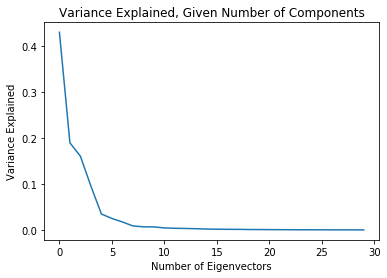

In [22]:
# Run PCA to help identify underlying traffic patterns per site

dfpca = StandardScaler().fit_transform(pivotpca)
fit = PCA()
pca = fit.fit_transform(dfpca)
plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")
k=4
print(fit.explained_variance_ratio_[:5])
print('{p}% of variance explained after {k} PCAs'.format(p=round(fit.explained_variance_ratio_[:k].sum()*100,1),k=k))

In [23]:
# Start building table from pca for plotting
dfpca = pd.DataFrame(pca[:, :4], index=pivotpca.index, columns=['pca1','pca2','pca3','pca4'])

# Append average hourly traffic per site
pivotavg = pd.pivot_table(df, values='hourly_counts', index='sensor_id', aggfunc=np.mean)
dfpca = dfpca.join(pivotavg, on='sensor_id')

# Append proportion of weekend traffic per site
pivotwkd = pd.pivot_table(df, values='hourly_counts', index='sensor_id', columns='day', aggfunc=np.mean)
pivotwkd['wkend_share'] = pivotwkd.iloc[:, -2:].sum(axis=1) / pivotwkd.iloc[:, :].sum(axis=1)
pivotwkd = pivotwkd['wkend_share']
dfpca = dfpca.join(pivotwkd, on='sensor_id')

# Append site names
dfpca = dfpca.join(names_table, on='sensor_id')
dfpca['sensor'] = (dfpca.index.map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + dfpca['sensor_name']

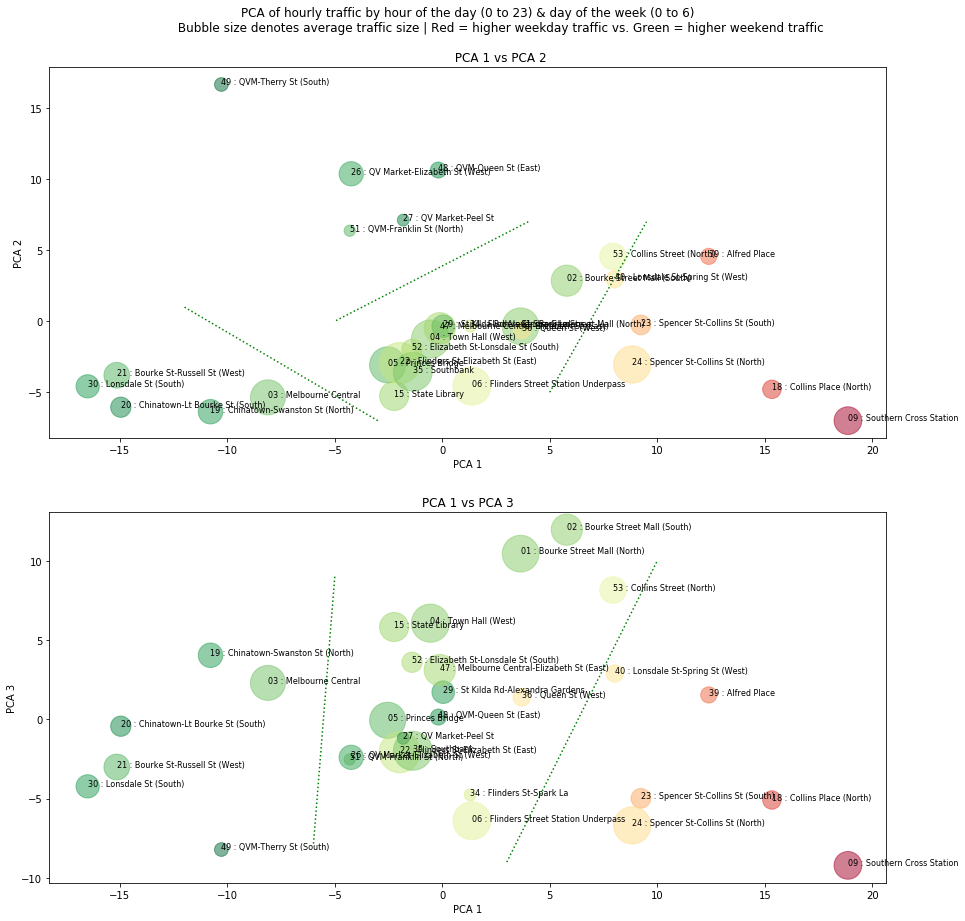

In [24]:
# Scatter plot to identify possible groupings of sites
fig, ax = plt.subplots(figsize=(15,15), ncols=1, nrows=2)
ax[0].set_title('PCA of hourly traffic by hour of the day (0 to 23) & day of the week (0 to 6)\n\
                 Bubble size denotes average traffic size | Red = higher weekday traffic vs. Green = higher weekend traffic\n\n\
                 PCA 1 vs PCA 2')
ax[1].set_title('PCA 1 vs PCA 3')

# Plot PCA 1 vs PCA 2
pcamap1 = ax[0].scatter(dfpca.pca1, dfpca.pca2, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[0].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca2, dfpca.iloc[i].sensor, fontsize=8)

# Plot PCA 1 vs PCA 3
pcamap2 = ax[1].scatter(dfpca.pca1, dfpca.pca3, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[1].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca3, dfpca.iloc[i].sensor, fontsize=8)

ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 3')
#fig.colorbar(pcamap1, orientation='horizontal', pad=0.05, shrink=0.3, ax=ax[1])

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[0].plot((5,9.5), (-5,7), ls=':', c='g')
ax[0].plot((4,-5), (7,0), ls=':', c='g')
ax[0].plot((-3,-12), (-7,1), ls=':', c='g')

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[1].plot((-5,-6), (9,-8), ls=':', c='g')
ax[1].plot((3,10), (-9,10), ls=':', c='g')

plt.show()

In [25]:
# # Visualize in 3D to get a full 3-way relationship
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Scatter3d(x=dfpca.pca1, y=dfpca.pca2,z=dfpca.pca3,
#       text=dfpca.sensor, mode='markers', marker=dict(sizeref=20, size=dfpca.hourly_counts,
#       color = dfpca.wkend_share, colorscale = 'RdYlGn')))
# fig.update_layout(height=600, width=800, scene = dict(xaxis=dict(title='PCA 1'),
#                   yaxis=dict(title='PCA 2'), zaxis=dict(title='PCA 3')))
# fig.show()

In [26]:
# Identify number of groups
group_name = {1: 'Mixed-use sites',
              2: 'Business sites',
              3: 'Leisure sites'}

# Assign each site ID to a group
# in format {sensor_ID:group_name}
grouped_site = { 1:1,  2:1,  3:1,  4:1,  5:1,  6:1,  9:2, 15:1, 18:2, 19:1,
                20:1, 21:1, 22:1, 23:2, 24:2, 26:3, 27:3, 29:1, 30:1, 34:1,
                35:1, 36:1, 39:2, 40:2, 47:1, 48:3, 49:3, 51:3, 52:1, 53:1}

df['group'] = df['sensor_id'].map(grouped_site)

In [27]:
# Prepare data to plot variations by group:
weekdays = [0,1,2,3,4]
weekends = [5,6]
groups   = list(group_name.keys())
hour_data_list = []
day_data_list = []

for period in ['hours','days']:
    if period=='hours':
        for days in [weekdays, weekends]:
            for group in groups:
                for total in [0,1]:
                    data = df[(df['day'].isin(days)) & (df['group']==group)]
                    cols1 = 'sensor_id' if total==0 else None                
                    sites = pd.pivot_table(data, values='hourly_counts', index='time',
                                           columns=cols1, aggfunc=np.nanmean)
                    cols2 = sites.columns if total==0 else None
                    sites = preprocessing.normalize(sites, norm='l1', axis=0)
                    hour_data_sites = pd.DataFrame(sites, index=range(0,24), columns=cols2)
                    hour_data_list.append((hour_data_sites, group, days))
    else:
        for group in groups:
            for total in [0,1]:
                data = df[df['group']==group]
                cols1 = 'sensor_id' if total==0 else None                
                sites = pd.pivot_table(data, values='hourly_counts', index='day',
                                       columns=cols1, aggfunc=np.nanmean)
                cols2 = sites.columns if total==0 else None
                sites = preprocessing.normalize(sites, norm='l1', axis=0)
                day_data_sites = pd.DataFrame(sites, index=range(0,7), columns=cols2)
                day_data_list.append((day_data_sites, group))

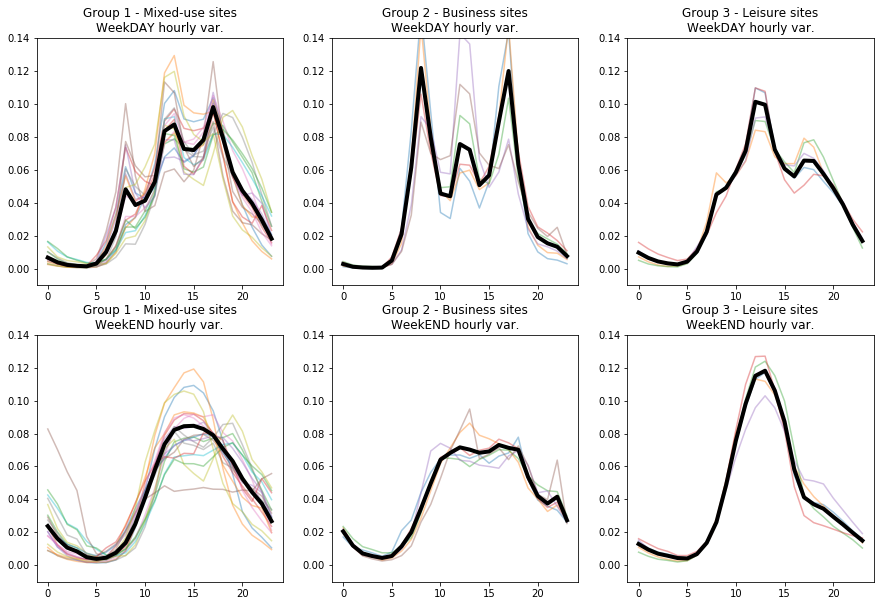

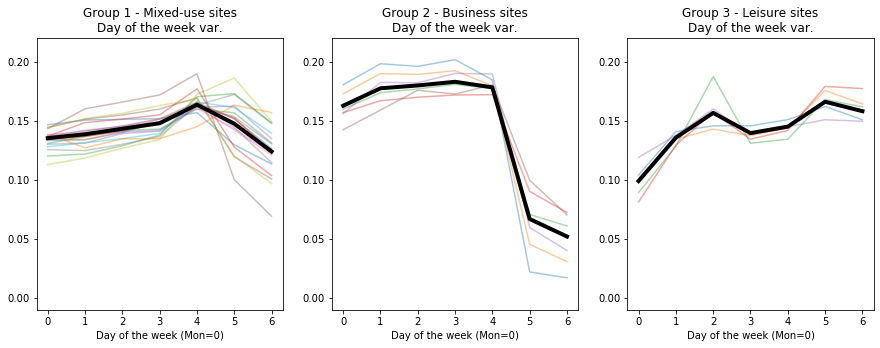

In [28]:
# Plot normalized hourly variation data
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for i, ax in zip(list(range(0,len(hour_data_list),2)), axes.flat):
    ax.plot(hour_data_list[i][0], alpha=0.4)
    ax.plot(hour_data_list[i+1][0], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.14)
    wkday = 'WeekDAY' if len(hour_data_list[i][2]) > 2 else 'WeekEND'
    grp = hour_data_list[i][1]
    ax.set_title('Group {g1} - {g2}\n{w} hourly var.'.format(g1=grp, g2=group_name[grp],w=wkday))

# Plot normalized day of the week variation data
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
for i, ax in zip(list(range(0,len(day_data_list),2)), axes.flat):
    ax.plot(day_data_list[i][0], alpha=0.4)
    ax.plot(day_data_list[i+1][0], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.22)
    ax.set_xlabel('Day of the week (Mon=0)')
    grp = hour_data_list[i][1]
    ax.set_title('Group {g1} - {g2}\nDay of the week var.'.format(g1=grp, g2=group_name[grp]))
plt.show()

In [29]:
# Aggregate similar sites together using group mean
# to formulate models by group instead of by invidual site.
# Mean is chosen in order to give more weight to sites with higher traffic.

dfs = df.copy()
dfs = dfs[['date_time', 'hourly_counts', 'group']]
dfs = pd.pivot_table(dfs, values='hourly_counts', index='date_time',
                     columns='group', aggfunc=np.mean)
dfs = dfs + 1 # for log transform
dfs.head(3)

group,1,2,3
date_time,,,
2018-01-01 00:00:00,1614.947368,729.333333,326.8
2018-01-01 01:00:00,1692.105263,412.833333,244.2
2018-01-01 02:00:00,979.421053,229.666667,129.2


# Neural Network - LSTM

### Train-test split

In [30]:
# Set train/test time split
train_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore') 
train_end    = pd.to_datetime('2019083123', format='%Y%m%d%H', errors='ignore')
test_start   = train_end  + pd.Timedelta(hours=1)
test_end     = pd.to_datetime('2020013123', format='%Y%m%d%H', errors='ignore')

# Assign train/test data frames
dfn = dfs.copy()
dfn_train = dfn.loc[train_start:train_end]
dfn_test  = dfn.loc[test_start:]
print('Test/train ratio: {r}'.format(r=round(len(dfn_test)/(len(dfn_train)+len(dfn_test)),2)))

Test/train ratio: 0.2


### Scale and assign by group

In [31]:
scaler = MinMaxScaler()
# Group 1
scaler.fit(np.array(dfn_train[1]).reshape(-1,1))
df1_train = (scaler.transform(np.array(dfn_train[1]).reshape(-1,1))).ravel()
df1_test  = (scaler.transform(np.array(dfn_test[1]).reshape(-1,1))).ravel()
# Group 2
scaler.fit(np.array(dfn_train[2]).reshape(-1,1))
df2_train = (scaler.transform(np.array(dfn_train[2]).reshape(-1,1))).ravel()
df2_test  = (scaler.transform(np.array(dfn_test[2]).reshape(-1,1))).ravel()
# Group 2
scaler.fit(np.array(dfn_train[3]).reshape(-1,1))
df3_train = (scaler.transform(np.array(dfn_train[3]).reshape(-1,1))).ravel()
df3_test  = (scaler.transform(np.array(dfn_test[3]).reshape(-1,1))).ravel()
# Show train & test sample
display(df1_train.shape, df1_test.shape)

(14592,)

(3672,)

In [32]:
# Function to split time series data into:
#   n consecutive time steps of data as X
#   and 1 time step of data as y

import numpy as np
def split_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # index of last element for each grouping of steps
        end_ix = i + n_steps
    # break condition at the end of the sequence
        if end_ix > len(data)-1:
            break
        # X = first n elements, y = the element after
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Set up and train neural network

In [33]:
import warnings
warnings.filterwarnings("ignore")

# Assign number of time steps & epochs
# n_steps = n sequence of X in time series followed by one Y
n_steps    = 24*7*4 # 4 weeks worth of hourly input to predict 1 future hour
batch_size = 24*7
epochs     = 10
n_features = 1

# Reshape X from [samples, steps] into [samples, steps, features]
# as the required Keras input format
X_train, y_train = split_data(df1_train, n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test, y_test = split_data(df1_test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Assign hyperparameters for model
cells1 = 64
cells2 = 64
activ1 = 'relu'
activ2 = 'relu'
optimizer='adam'
loss='mse'
metrics=['mse', 'mae', 'mape', 'cosine']

# Define and fit model
model = Sequential()
model.add(LSTM(cells1, activation=activ1, input_shape=(n_steps, n_features),
               return_sequences=True))
model.add(LSTM(cells1, activation=activ1,
               return_sequences=True))
model.add(LSTM(cells1, activation=activ1,
               return_sequences=True))
model.add(LSTM(cells2, activation=activ2))
model.add(Dense(1))

In [34]:
# # Train model
# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# history = model.fit(X_train, y_train, epochs=epochs,
#                      batch_size=batch_size, verbose=1,
#                      validation_data=(X_test, y_test))

# # Pickle results
# filename = 'saved_models/pickle_lstm_base_model.sav'
# pickle.dump(model, open(filename, 'wb'))
# filename = 'saved_models/pickle_lstm_base_history.sav'
# pickle.dump(history, open(filename, 'wb'))

### Evaluate baseline results

In [35]:
# Open baseline from pickle
filename = 'saved_models/pickle_lstm_base_model.sav'
model = pickle.load(open(filename, 'rb'))
filename = 'saved_models/pickle_lstm_base_history.sav'
history = pickle.load(open(filename, 'rb'))

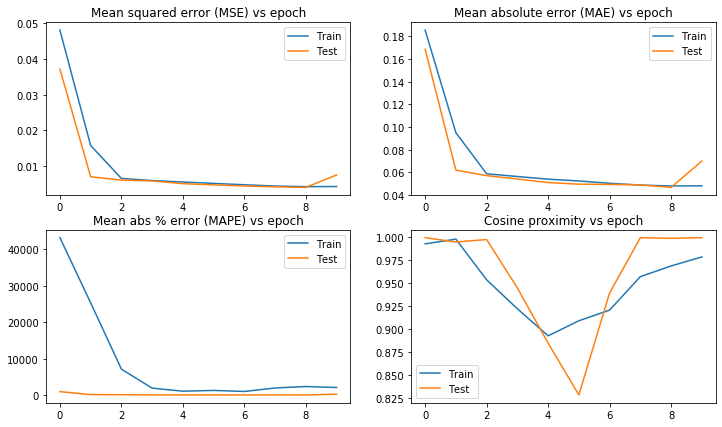

In [36]:
# Plot metrics vs num of epochs
metrics=['mse', 'mae', 'mape', 'cosine']
titles =['Mean squared error (MSE) vs epoch', 'Mean absolute error (MAE) vs epoch',
         'Mean abs % error (MAPE) vs epoch', 'Cosine proximity vs epoch']

fig, axes = plt.subplots(2,2, figsize=(12,7))
for i, ax in zip(range(len(metrics)), axes.flat):
    ax.plot(history.history[metrics[i]], label='Train')
    ax.plot(history.history['val_{metrics}'.format(metrics=metrics[i])], label='Test')
    ax.set_title(titles[i])
    ax.legend()
plt.show()

### Prediction using baseline

In [37]:
# Select the number of days to be predicted beyond the last data in source
future_days  = 7
future_hours = 24 * future_days

# # Select pickled model to use for prediction
# filename = 'saved_models/pickle_lstm_base_model4.sav'
# model = pickle.load(open(filename, 'rb'))
# # Set n_steps to match params used in pickled model (if different)
# n_steps = 24*7*8

# # Initialize input with final train sequence
# final_train = df1_train[-n_steps:]

# # Run prediction for future_hours and store
# prediction_output = []
# test = []
# input = final_train
# for i in range(future_hours):
#     prediction = model.predict(input.reshape((1, n_steps, n_features)))
#     prediction_output.append(prediction.ravel()[0])
#     # Updated input = train input excluding final n + first n predictions
#     input = np.append(final_train[(i+1):], prediction_output[:(i+1)])
    
# # Pickle prediction
# filename = 'saved_models/pickle_lstm_base_predict1_recalc4.sav'
# pickle.dump(prediction_output, open(filename, 'wb'))

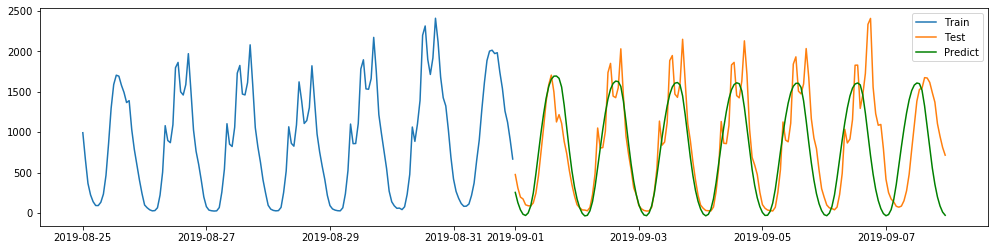

In [38]:
# Open from pickle
filename = 'saved_models/pickle_lstm_base_predict1_recalc4.sav'
prediction_output = pickle.load(open(filename, 'rb'))

# Scaler for total Group 1
scaler = MinMaxScaler()
scaler.fit(np.array(dfn_train[1]).reshape(-1,1))

# Inverse transform and assign to dataframe (NEW)
pred = scaler.inverse_transform(np.array(prediction_output).reshape(-1, 1))
df_pred = pd.DataFrame(pred, index=dfn_test[1][:future_hours].index)

# Plot train, test and predict
fig, ax = plt.subplots(figsize=(17,4))
plt.plot(dfn_train[1][-(24*7):], label='Train')
plt.plot(dfn_test[1][:future_hours], label='Test')
plt.plot(df_pred, label='Predict', c='g')
plt.legend()
plt.show()

# SARIMA model

### Train-test split

In [39]:
# Set train/test time split
one_week    = pd.Timedelta(hours=7*24)
data_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore')
test_start  = pd.to_datetime('2019082600', format='%Y%m%d%H', errors='ignore') # Mon midnight
train_start = test_start - one_week * 3  # for analysis; can be tweaked later
train_end   = test_start
test_end    = test_start + one_week      # for analysis; can be tweaked later

# Assign train/test data frames
dfs_pre_test = dfs.loc[:test_start]
dfs_test     = dfs.loc[test_start:]

### Data decomposition & stationarity

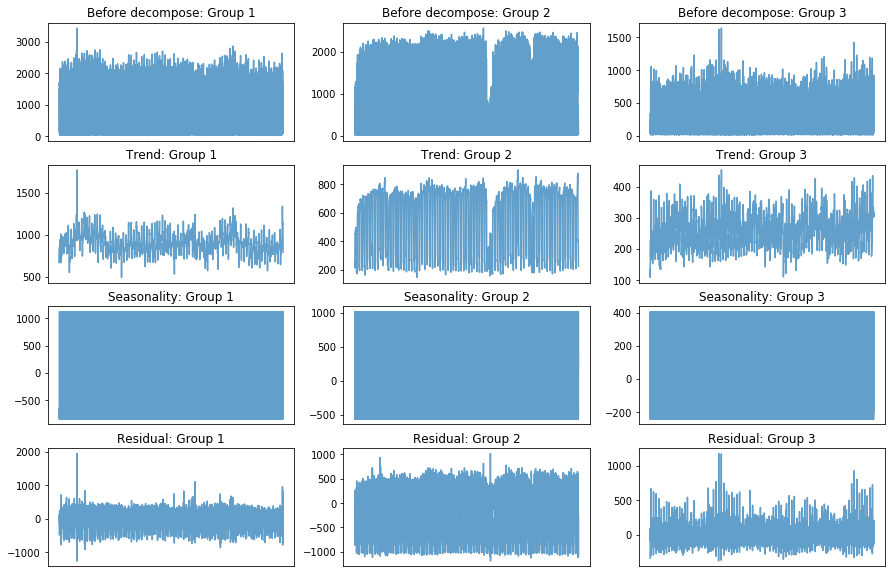

In [40]:
# Time series data composition per group
from statsmodels.tsa.seasonal import seasonal_decompose
groups = [1,2,3]
def decomp_list(dfs, groups):
    decomp, titles = [], []
    for group in groups:
        data = dfs_pre_test[group]
        d    = seasonal_decompose(data,model='additive')
        decomp.append(data)
        titles.append('Before decompose: Group {g}'.format(g=group))
        decomp.append(d.trend)
        titles.append('Trend: Group {g}'.format(g=group))
        decomp.append(d.seasonal)
        titles.append('Seasonality: Group {g}'.format(g=group))
        decomp.append(d.resid)
        titles.append('Residual: Group {g}'.format(g=group))
    return decomp, titles

decomp, titles = decomp_list(dfs, groups)
order = {0:0, 1:4, 2:8, 3:1, 4:5, 5:9, 6:2, 7:6, 8:10, 9:3, 10:7, 11:11}
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(15,10))
for n, ax in zip(range(12), axes.flat):
    ax.plot(decomp[order[n]], alpha=0.7)
    ax.set_title(titles[order[n]], fontsize=12)
    ax.set_xticks([])
plt.show()

In [41]:
# Calculate p-value of stationarity test over 1.5-year period

from statsmodels.tsa.stattools import adfuller
print('Verify stationarity using Dickey-Fuller test (p-value < 0.05):')
for group in groups:
    print('p-value for Group {g}: {af}'.format(g=group,af=adfuller(dfs_pre_test[group])[1]))

Verify stationarity using Dickey-Fuller test (p-value < 0.05):
p-value for Group 1: 1.6283625003593674e-21
p-value for Group 2: 2.6788254538253947e-30
p-value for Group 3: 3.247904873115661e-30


## Group 1 general model

### Seasonal differencing

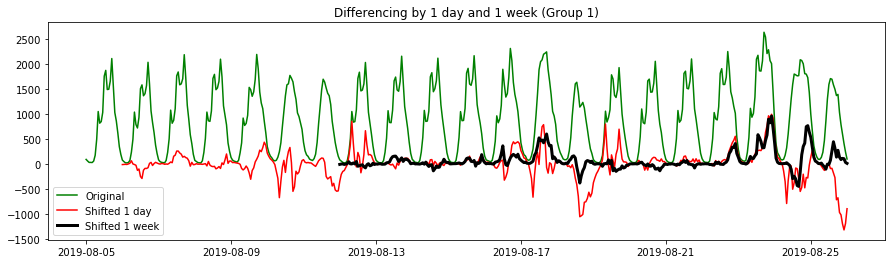

In [42]:
# Difference data by a day and by a week for Group 1
data = dfs[1][train_start:test_start]
data_shift_day  = data - data.shift(24)
data_shift_week = data - data.shift(24*7)
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data, c='green', label='Original')
plt.plot(data_shift_day,  c='red', label='Shifted 1 day')
plt.plot(data_shift_week, c='black', lw=3, label='Shifted 1 week')
ax.set_title('Differencing by 1 day and 1 week (Group 1)')
plt.legend()
plt.show()

### Autocorrelation (ACF) & Partial Autocorrelation (PACF)

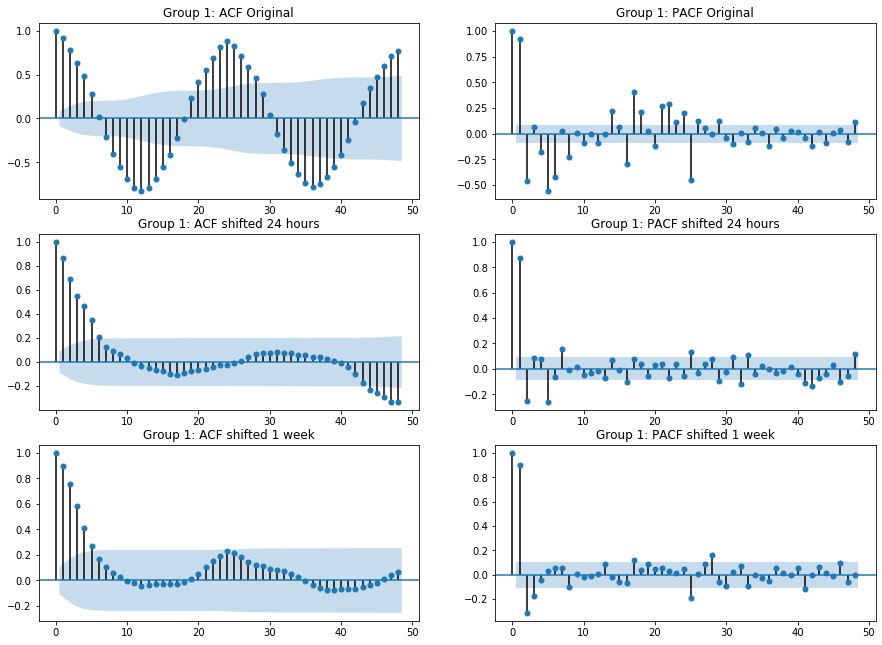

In [43]:
# Zoom in lags over 2 days
lags = 24*2 # hours
one_day = pd.Timedelta(hours=24)

# Adjust time window since shifted data has null values at the start
data_shift_day_p  = data_shift_day[train_start + one_day:]
data_shift_week_p = data_shift_week[train_start + one_day * 7:]

# Plot ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,11))
plot_acf (data, lags=lags, ax=axes.flat[0], title='Group 1: ACF Original')
plot_pacf(data, lags=lags, ax=axes.flat[1], title='Group 1: PACF Original')
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='Group 1: ACF shifted 24 hours')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='Group 1: PACF shifted 24 hours')
plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[4], title='Group 1: ACF shifted 1 week')
plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[5], title='Group 1: PACF shifted 1 week');

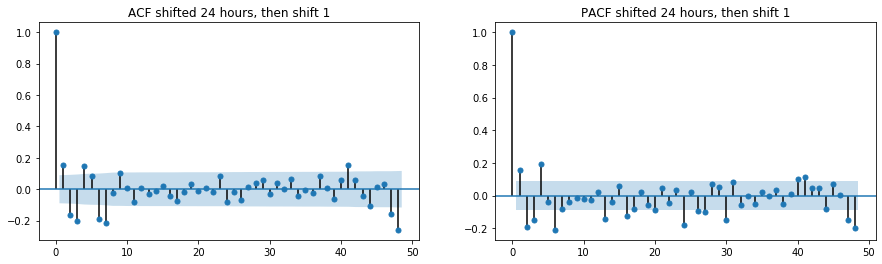

In [44]:
# Now shift the 24-hour shift by 1 since ACF is not decaying fast
data_shift_day1   = data_shift_day - data_shift_day.shift(1)
data_shift_day1_p  = data_shift_day1[train_start + one_day + pd.Timedelta(hours=1):]

# Replot ACF & PCF
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
plot_acf (data_shift_day1_p, lags=lags, ax=axes.flat[0], title='ACF shifted 24 hours, then shift 1')
plot_pacf(data_shift_day1_p, lags=lags, ax=axes.flat[1], title='PACF shifted 24 hours, then shift 1');

In [45]:
# Determine baseline SARIMA parameters from the latest ACF & PACF
# (24-hour shift, then 1 more shift)

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # 2 if in PACF 24 & 48 are significant
D = 1  # follows d
Q = 2  # 2 if in ACF 24 & 48 are significant

### Hyperparameter grid search

In [46]:
# Hyperparameter list to test
p_list = [6,7,13,16,17,20,24]
q_list = [6,7,8,9,10]
P_list = [1,2]
Q_list = [1,2]
d, D, m = 1, 1, 24

print('No of combinations: {c}'.format(c=len(p_list) * len(q_list) * len(P_list) * len(Q_list)))

num_of_wks = 2
train_start = test_start - one_week * num_of_wks
data_arima = dfs[1][train_start : test_start]

No of combinations: 140


In [47]:
# # Optimize hyperparameters for Group 1
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# # Iterate through hyperparam list to train SARIMA model
# sample_size = len(data_arima)
# results = []
# for p in p_list:
#   for q in q_list:
#     try:
#       model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
#     except:
#       continue
#     aic = model.aic
#     if aic < 1e10: # if fail to converge
#       best_aic = aic
#     results.append([p, d, q, P, D, Q, m, sample_size, round(aic,1)])

#   result_table = pd.DataFrame(results)
#   result_table.columns = ['p','d','q','P','D','Q','m','samples','AIC']
#   result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
  
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

# # Save result table in pickle
# filename = 'saved_models/pickle_sarima_optimization.sav'
# pickle.dump(result_table, open(filename, 'wb'))

In [48]:
# Open hyperparameter list from pickle
filename = 'saved_models/pickle_sarima_optimization.sav'
sarima_hyperparams = pickle.load(open(filename, 'rb'))
print('Top 3 hyperparameters from grid search sorted by AIC:')
display(sarima_hyperparams[:3])

Top 3 hyperparameters from grid search sorted by AIC:


,p,d,q,P,D,Q,m,samples,AIC
0,7,1,6,2,1,2,24,337,3810.3
1,6,1,6,2,1,2,24,337,3812.0
2,6,1,8,2,1,2,24,337,3813.2


In [49]:
# # Set training length and data set
# num_of_wks = 8
# train_start = test_start - one_week * num_of_wks
# data_arima = dfs[1][train_start : test_start]

# # Run SARIMA model with optimized parameters
# p,d,q,P,D,Q,m = sarima_hyperparams.iloc[0][:7].astype(int)
# model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# # Pickle SARIMA trained model
# filename = 'saved_models/pickle_sarima.sav'
# pickle.dump(model, open(filename, 'wb'))

In [50]:
# Open pickled SARIMA after training and show summary
filename = 'saved_models/pickle_sarima_v2.sav'
sarima = pickle.load(open(filename, 'rb'))
print(sarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       1   No. Observations:                  505
Model:             SARIMAX(7, 1, 6)x(2, 1, [1, 2], 24)   Log Likelihood               -2925.268
Date:                                 Tue, 03 Mar 2020   AIC                           5886.536
Time:                                         09:08:21   BIC                           5961.664
Sample:                                     08-05-2019   HQIC                          5916.067
                                          - 08-26-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2612      0.400     -0.652      0.514      -1.046       0

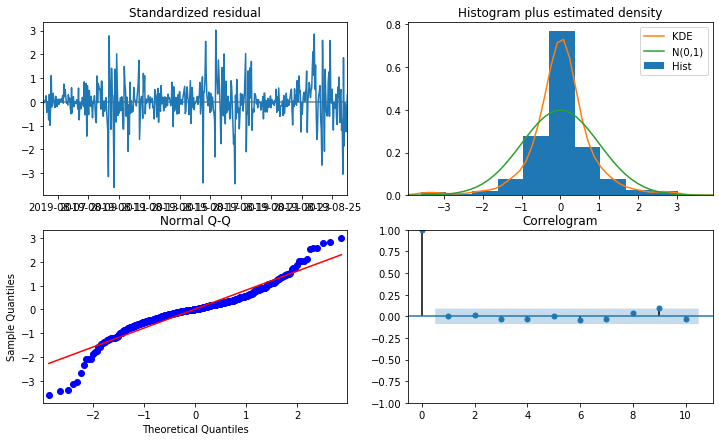

In [51]:
# Check assumptions of SARIMA model results
sarima.plot_diagnostics(figsize=(12,7));

### Visualize prediction for one week ahead

In [52]:
# Formula to calculate SARIMA prediction and confidence interval

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

def predict_sarima(model, data, scaler, test_start, train_plot_weeks, test_plot_weeks):
    one_week   = pd.Timedelta(hours=7*24)
    plot_start = test_start - one_week * train_plot_weeks
    test_end   = test_start + one_week * test_plot_weeks

    data_train = data[plot_start : test_start]
    data_test  = data[test_start : test_end]

    # Calc prediction
    pred = model.predict(start=test_start, end=test_end, dynamic=True)
    # Calc confidence interval
    pred_conf = model.get_forecast(len(pred)).conf_int()

    if scaler!=None:  
        # Inverse transform then calc prediction
        pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
        pred = pd.DataFrame(pred, index=data_test.index)
        # Inverse transform then calc confidence interval
        pred_conf = scaler.inverse_transform(pred_conf)
        pred_conf = pd.DataFrame(pred_conf, index=data_test.index,
                                  columns=['upper 1','lower 1'])        
        
    # Upper and lower confidence intervals
    pc_upper = pred_conf.iloc[:,1]
    pc_lower = pred_conf.iloc[:,0]
    
    return pred, pc_upper, pc_lower, data_train, data_test

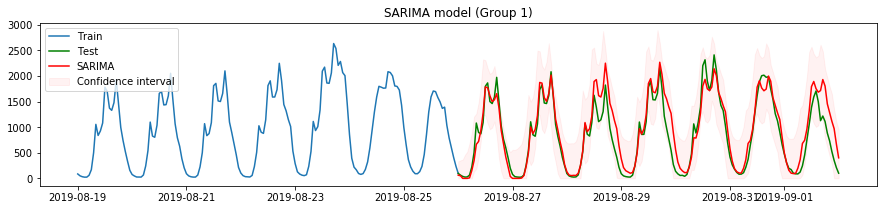

In [53]:
# Assign parameters
model, data, scaler, test_start = sarima, dfs[1], None, test_start
pred0, pc_upper0, pc_lower0, train, test = predict_sarima(model, data, scaler, test_start, 1, 1)

# Visualize train, test and prediction to calc prediction
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(train, label='Train')
plt.plot(test, label='Test', c='g')
plt.plot(pred0.clip(0), label='SARIMA', c='r')
plt.fill_between(test.index, pc_upper0, pc_lower0.clip(0), color='r', alpha=.05, label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model (Group 1)')
plt.show()

### Rerun model with day of the week as eXogenous variable

In [54]:
# Function to generate exog variables
import pandas as pd
def exog_days(data):
    exog_days = pd.DataFrame(data.index)
    exog_days['wkday']  = exog_days['date_time'].dt.dayofweek
    for day in range(0,7):
        col_name = 'day{d}'.format(d=day)
        exog_days[col_name] = exog_days['wkday'].map(lambda row: 1 if row==day else 0)
    exog_days = exog_days.iloc[:,2:].values
    return exog_days

In [55]:
# # Set training length and data set
# num_of_wks = 2
# train_start = test_start - one_week * num_of_wks
# data_arima = dfs[1][train_start : test_start]

# # Run SARIMA model with EXOG
# exog_days_train = exog_days(data_arima)
# p,d,q,P,D,Q,m = sarima_hyperparams.iloc[0][:7].astype(int)
# model = SARIMAX(endog=data_arima, exog=exog_days_train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# # Pickle SARIMA trained model
# filename = 'saved_models/pickle_sarima_exog.sav'
# pickle.dump(model, open(filename, 'wb'))

In [56]:
# Open pickled SARIMA after training and show summary
filename = 'saved_models/pickle_sarima_exog.sav'
sarimaX = pickle.load(open(filename, 'rb'))

# Calc exog variables for prediction period
exog_days_test = exog_days(test)
# Run prediction
predX = sarimaX.predict(start=test_start, end=test_end, exog=exog_days_test[:-1], dynamic=True)

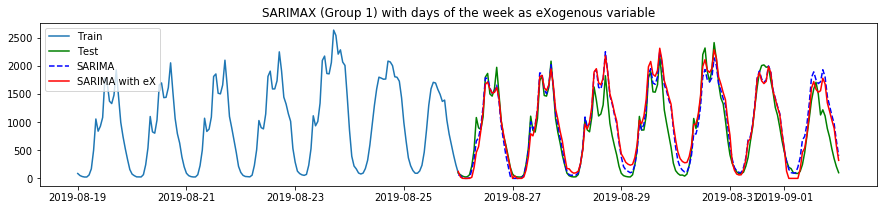

In [57]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(train, label='Train')
plt.plot(test, label='Test', c='g')
plt.plot(pred0.clip(0), c='b', ls='dashed', label='SARIMA')
plt.plot(predX.clip(0), c='r', label='SARIMA with eX')
ax.set_title('SARIMAX (Group 1) with days of the week as eXogenous variable')
plt.legend()
plt.show()

### Rerun model using seasonality equal to 7 days instead of 24 hours

In [58]:
# Assign hyperparams
p,d,q,P,D,Q,m = sarima_hyperparams.iloc[0][:7].astype(int)

# Reassign m to 1 week instead of 1 day
m = 24*7

# Select data
num_of_wks = 3
train_start = test_start - one_week * num_of_wks
data_arima = dfs[1][train_start : test_start]

In [59]:
# Fit and transform for model input with Standard Scaler
stdscaler = StandardScaler()
stdscaler.fit(np.array(data_arima).reshape(-1, 1))
data_arima_stdscaled = stdscaler.transform(np.array(data_arima).reshape(-1, 1)).ravel()
data_arima_stdscaled = pd.DataFrame(data_arima_stdscaled, index=data_arima.index)

In [60]:
# start = time.time()
# print('Start: {t}'.format(t=(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))))

# # Run SARIMA with one-week seasonality
# model = SARIMAX(data_arima_stdscaled, order=(p, d, q),
#                 seasonal_order=(P, D, Q, m)).fit()
# print('End: {t} in {m} minutes'.format(t=datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S"), m=round((time.time()-start)/60,1)))

# # Pickle model results
# filename = 'saved_models/pickle_sarima_m168_v2.sav'
# pickle.dump(model, open(filename, 'wb'))

In [61]:
# # Open pickled baseline after training
# filename = 'saved_models/pickle_sarima_m168_v2.sav'
# base168 = pickle.load(open(filename, 'rb'))

# # Summary of results
# base168summary = base168.summary()
# filename = 'saved_models/pickle_sarima_m168_v2_summary.sav'
# pickle.dump(base168summary, open(filename, 'wb'))

# # Diagnostic plots
# base168diag = base168.plot_diagnostics(figsize=(12,7))
# filename = 'saved_models/pickle_sarima_m168_v2_diag.sav'
# pickle.dump(base168diag, open(filename, 'wb'))

In [62]:
# Display model summary
filename = 'saved_models/pickle_sarima_m168_v2_summary.sav'
base168summary = pickle.load(open(filename, 'rb'))
print(base168summary)

                                        SARIMAX Results                                         
Dep. Variable:                                        0   No. Observations:                  505
Model:             SARIMAX(7, 1, 6)x(2, 1, [1, 2], 168)   Log Likelihood                 284.150
Date:                                  Mon, 02 Mar 2020   AIC                           -532.301
Time:                                          08:53:29   BIC                           -463.593
Sample:                                      08-05-2019   HQIC                          -504.912
                                           - 08-26-2019                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2768      1.605     -0.172      0.863      -3.422

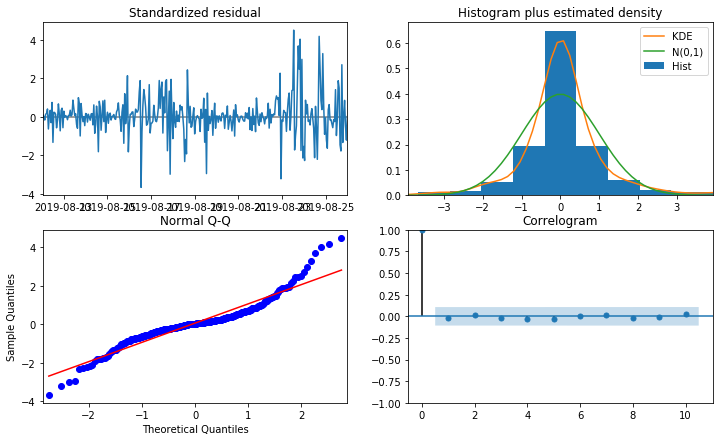

In [63]:
# Check assumptions of SARIMA model results
filename = 'saved_models/pickle_sarima_m168_v2_diag.sav'
base168diag = pickle.load(open(filename, 'rb'))
base168diag;

In [64]:
# PLOT PREDICTION WHEN NEW MODEL IS READY

### Evaluate prediction when deployed to individual sites using Group 1 generic model

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

def sarima_mse(model, data, scaler, test_start, test_plot_weeks):
    one_week   = pd.Timedelta(hours=7*24)
    test_end   = test_start + one_week * test_plot_weeks
    data_test0 = data[test_start : test_end]

    # Standardized test data:
    scaler = scaler.fit(np.array(data_test0).reshape(-1, 1))
    data_test = scaler.transform(np.array(data_test0).reshape(-1, 1)).ravel()
    data_test = pd.DataFrame(data_test, index=data_test0.index)

    # Standardized predictions:
    # Calc prediction
    pred = model.predict(start=test_start, end=test_end, dynamic=True)
    # Calc confidence interval
    pred_conf = model.get_forecast(len(pred)).conf_int()
    # Calc confidence intervals
    pc_upper = pred_conf.iloc[:,1]
    pc_lower = pred_conf.iloc[:,0]

    # Non-standardized predictions:
    if scaler!=None:  
        # Inverse transform then calc prediction
        pred0 = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
        pred0 = pd.DataFrame(pred0, index=data_test0.index)
        # Inverse transform then calc confidence interval
        pred_conf0 = scaler.inverse_transform(pred_conf)
        pred_conf0 = pd.DataFrame(pred_conf0, index=data_test0.index,
                                  columns=['upper 1','lower 1'])
        # Calc confidence intervals
        pc_upper0 = pred_conf0.iloc[:,1]
        pc_lower0 = pred_conf0.iloc[:,0]
    
    return data_test, pred, pc_upper, pc_lower, data_test0, pred0, pc_upper0, pc_lower0

In [66]:
# Pivot all data to get site-level format
dfsite = df.copy()
dfsite = dfsite[['date_time', 'hourly_counts', 'sensor_id']]
dfsite = pd.pivot_table(dfsite, values='hourly_counts', index='date_time',
                      columns='sensor_id', aggfunc=np.mean)

# # Select parameters
# model = base168
# test_start = test_start
# scaler = StandardScaler()

# # Build table of predictions for all sites
# cols=['sensor_id', 'group', 'test','predict','lower','upper',
#       'std_test','std_predict','std_lower', 'std_upper']
# dfpredict = pd.DataFrame(columns=cols)

# for site in df.sensor_id.unique():
#     data = dfsite[site]
#     data_test, pred, pc_upper, pc_lower, data_test0, pred0, pc_upper0, pc_lower0 = sarima_mse(model, data, scaler, test_start, 1)

#     dfpred = pd.DataFrame({'predict':pred0.values.ravel().clip(0), 'test':data_test0.values.ravel(),
#                            'upper':pc_upper0.values.ravel(), 'lower':pc_lower0.values.ravel().clip(0),
#                            'std_predict':pred.values.ravel().clip(data_test.min()[0]),
#                            'std_test':data_test.values.ravel(), 'std_upper':pc_upper.values.ravel(),
#                            'std_lower':pc_lower.values.ravel().clip(data_test.min()[0])},
#                           index=data_test.index)
#     dfpred[['test','predict','lower','upper']] = dfpred[['test','predict','lower','upper']].astype('int')
#     dfpred['sensor_id'] = site
#     dfpred['group'] = dfpred['sensor_id'].map(grouped_site)
#     dfpred = dfpred[cols]
#     dfpredict = pd.concat([dfpredict, dfpred])

# dfpredict.to_csv('files/dfpredict.csv')

In [67]:
# Read from saved prediction table
dfpredict = pd.read_csv('files/dfpredict.csv', index_col=0)
dfpredict.index = pd.to_datetime(dfpredict.index)
dfpredict.iloc[9:12] # 9am to 11am sample

,sensor_id,group,test,predict,lower,upper,std_test,std_predict,std_lower,std_upper
2019-08-26 09:00:00,1,1,935,1439,867,2287,-0.318612,0.058158,-0.369254,0.691939
2019-08-26 10:00:00,1,1,1348,1577,1236,2659,-0.010061,0.161139,-0.093516,0.969929
2019-08-26 11:00:00,1,1,1877,1947,2536,3960,0.385152,0.438115,0.877603,1.941478


In [68]:
# Create a pivot summary table showing:

# Rows: group, sensor_id
# Columns: standardized MSE (weekdays), standardized MSE (weekend)

Evaluate prediction of Group 1 standard model when deployed to indvidual sites in Group 1:

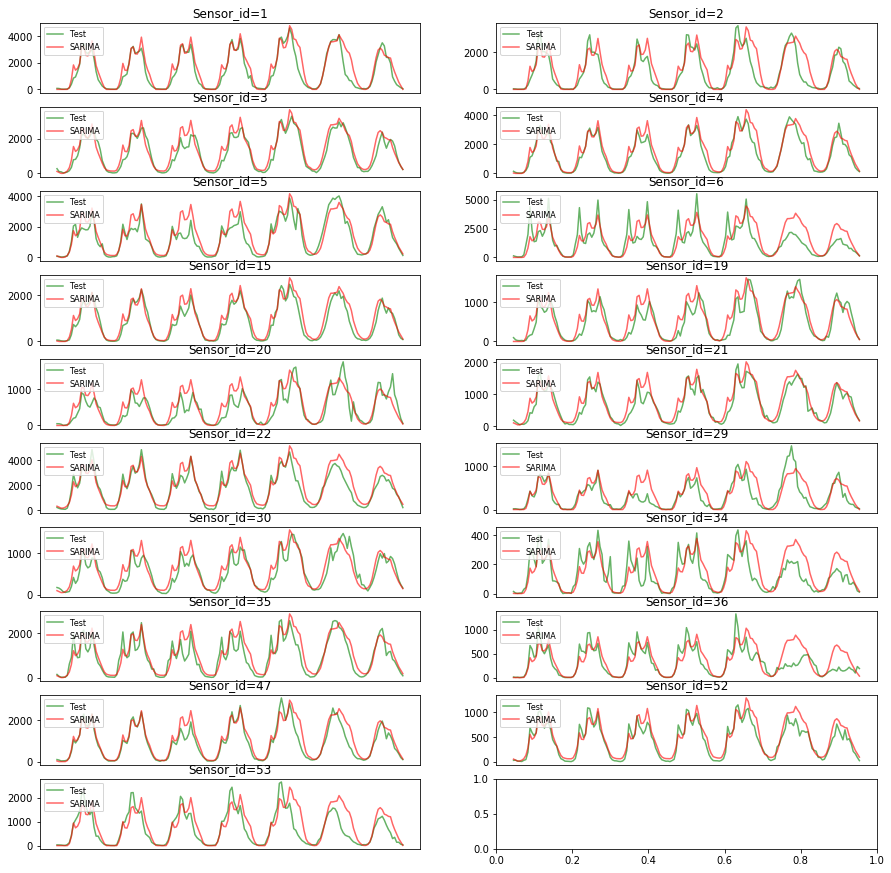

In [69]:
# Visualize test vs prediction for Group 1 locations:
group_num = 1
group_list = []
for key, value in grouped_site.items():
    if value==group_num: group_list.append(key)

fig, axes = plt.subplots(ncols=2, nrows=round(len(group_list)/2), figsize=(15, len(group_list)*0.8))
for i, ax in zip(range(len(group_list)), axes.flat):
    ax.plot(dfpredict[dfpredict.sensor_id==group_list[i]].iloc[:,2], label='Test', c='g', alpha=0.6)
    ax.plot(dfpredict[dfpredict.sensor_id==group_list[i]].iloc[:,3], label='SARIMA', c='r', alpha=0.6)
    ax.set_title('Sensor_id={id}'.format(id=group_list[i]))
    ax.legend(loc='upper left', fontsize=8)
    ax.set_xticks([])
plt.show()

Evaluate prediction of Group 1 standard model when deployed to indvidual sites in Group 2:

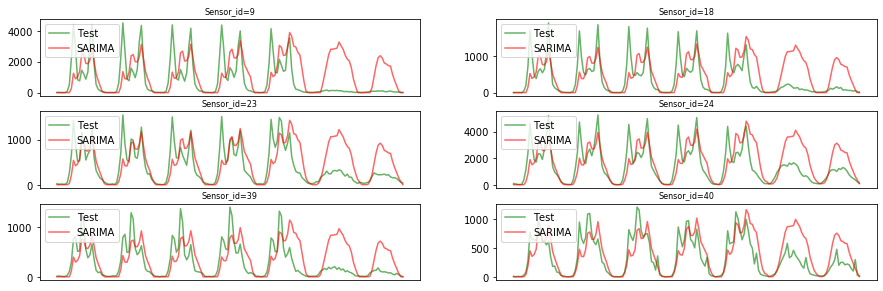

In [70]:
# Visualize test vs prediction for Group 2 locations:
group_num = 2
group_list = []
for key, value in grouped_site.items():
    if value==group_num: group_list.append(key)

fig, axes = plt.subplots(ncols=2, nrows=round(len(group_list)/2), figsize=(15, len(group_list)*0.8))
for i, ax in zip(range(len(group_list)), axes.flat):
    ax.plot(dfpredict[dfpredict.sensor_id==group_list[i]].iloc[:,2], label='Test', c='g', alpha=0.6)
    ax.plot(dfpredict[dfpredict.sensor_id==group_list[i]].iloc[:,3], label='SARIMA', c='r', alpha=0.6)
    ax.set_title('Sensor_id={id}'.format(id=group_list[i]), fontsize=8)
    ax.legend(loc='upper left')
    ax.set_xticks([])
plt.show()

Evaluate prediction of Group 1 standard model when deployed to indvidual sites in Group 3:

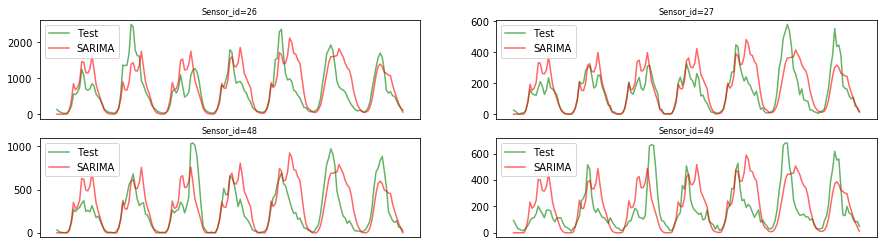

In [71]:
# Visualize test vs prediction for Group 3 locations:
group_num = 3
group_list = []
for key, value in grouped_site.items():
    if value==group_num: group_list.append(key)

fig, axes = plt.subplots(ncols=2, nrows=round(len(group_list)/2), figsize=(15, len(group_list)*0.8))
for i, ax in zip(range(len(group_list)), axes.flat):
    ax.plot(dfpredict[dfpredict.sensor_id==group_list[i]].iloc[:,2], label='Test', c='g', alpha=0.6)
    ax.plot(dfpredict[dfpredict.sensor_id==group_list[i]].iloc[:,3], label='SARIMA', c='r', alpha=0.6)
    ax.set_title('Sensor_id={id}'.format(id=group_list[i]), fontsize=8)
    ax.legend(loc='upper left')
    ax.set_xticks([])
plt.show()

### Find hyperparameters for Groups 2 & 3

#### Seasonal differencing

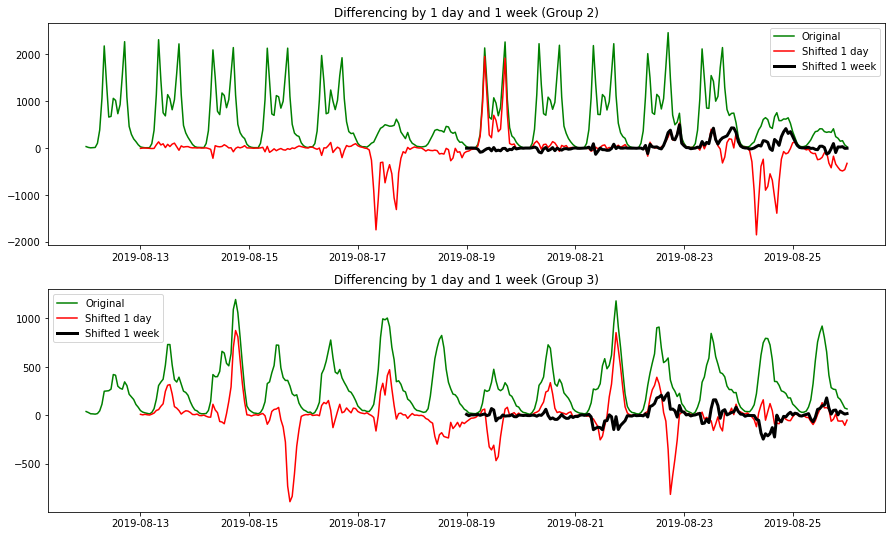

In [72]:
# Difference data by a day and by a week for Group 2 & 3
train_start = test_start - one_week*2
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,9))
group = [2,3]
for i, ax in zip(range(2), ax.flat):
    data = dfs[group[i]][train_start:test_start]
    data_shift_day  = data - data.shift(24)
    data_shift_week = data - data.shift(24*7)
    ax.plot(data, c='green', label='Original')
    ax.plot(data_shift_day,  c='red', label='Shifted 1 day')
    ax.plot(data_shift_week, c='black', lw=3, label='Shifted 1 week')
    ax.set_title('Differencing by 1 day and 1 week (Group {g})'.format(g=group[i]))
    ax.legend()
plt.show()

#### Autocorrelation (ACF) & Partial Autocorrelation (PACF)

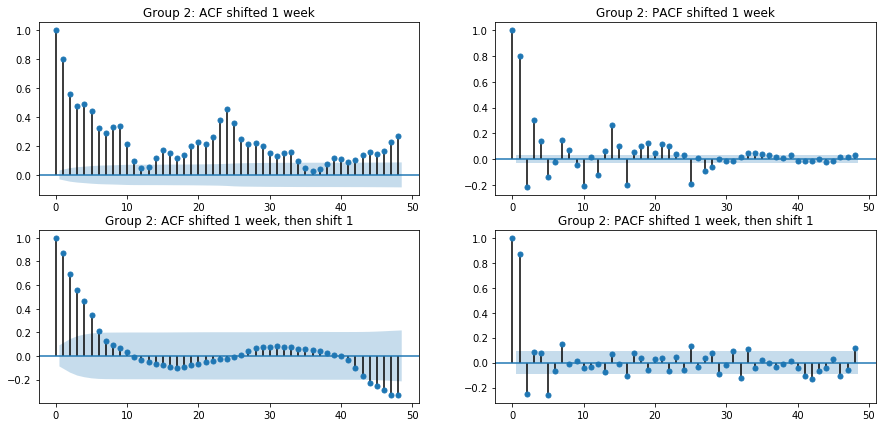

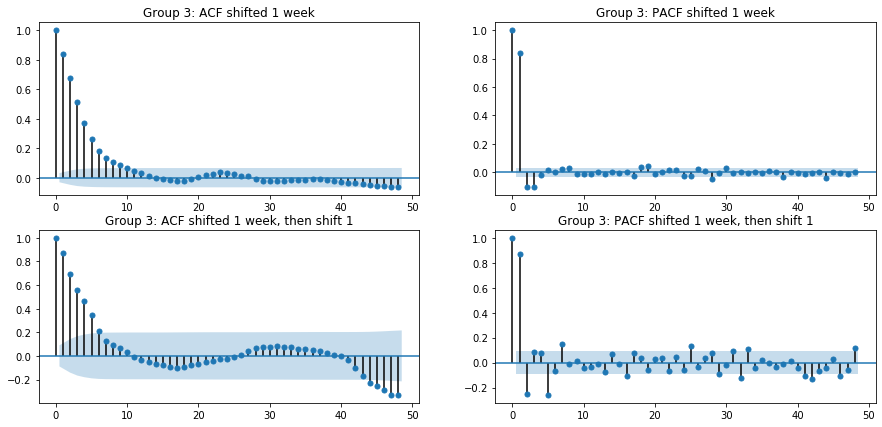

In [73]:
# Zoom in lags over 2 days
lags = 24*2
one_day = pd.Timedelta(hours=24)

for g in group:
    data = dfs[g]
    # Adjust time window since shifted data has null values at the start
    data_shift_week   = data - data.shift(24*7)
    data_shift_week1  = data_shift_week - data_shift_week.shift(1)
    # For plotting
    data_shift_week_p = data_shift_week[train_start + one_day * 7:]
    data_shift_week1_p= data_shift_week1[train_start + one_week + pd.Timedelta(hours=1):]
    # Plot ACF & PCF
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,7))
    plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[0], title='Group {g}: ACF shifted 1 week'.format(g=g))
    plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[1], title='Group {g}: PACF shifted 1 week'.format(g=g))
    plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='Group {g}: ACF shifted 1 week, then shift 1'.format(g=g))
    plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='Group {g}: PACF shifted 1 week, then shift 1'.format(g=g));

In [74]:
# Determine Group 2 parameters from ACF & PACF
p = 6    # lag from PACF
d = 1    # non-seasonal differences taken to get stationarity
q = 7    # lag from ACF
m = 24*7 # cycle repeats after one week
P = 2    # significant cycles
D = 1    # follows d
Q = 2    # significant cycles

# Determine Group 3 parameters from ACF & PACF
p = 6    # lag from PACF
d = 1    # non-seasonal differences taken to get stationarity
q = 7    # lag from ACF
m = 24*7 # cycle repeats after one week
P = 2    # significant cycles
D = 1    # follows d
Q = 2    # significant cycles

### Prepare for visualisation

In [75]:
# Formula to create 'roads' on grid map
def fill_roads(array, horiz=1, fixed=0, start=0, stop=0, fill=1):
    if horiz == 1:
        for col in range(start, stop+1):
            array[fixed][col] = fill
    else:
        for row in range(start, stop+1):
            array[row][fixed] = fill
    return array

In [76]:
# Create data for CBD roads
import numpy as np

# Blank grid data
base_data = np.empty((61, 69))
base_data[:] = np.nan

# Yarra River
yarra_river =  [[1, 0, 52, 54], # format: horiz=1, row, start_col, end_col
                [1, 1, 52, 54],
                [1, 2, 52, 54],
                [1, 3, 51, 54],
                [1, 4,  0, 54],
                [1, 5,  0, 53],
                [1, 6,  0, 52]]
for river in yarra_river:
    fill_roads(base_data, *river, 0)

# South-to-North roads
horiz_roads = [[1,  7, 18, 22],
               [1, 10,  0, 68], # format: horiz=1, row, start_col, end_col
               [1, 18,  0, 68],
               [1, 26,  2, 66],
               [1, 30, 43, 65],
               [1, 34,  0, 68],
               [1, 42,  0, 68],
               [1, 50, 16, 52],
               [1, 58, 16, 36]]
for road in horiz_roads:
    fill_roads(base_data, *road, 1)

# West-to-East roads
vert_roads  = [[0,  2,  0, 44], # format: horiz=0, col, start_row, end_col
               [0, 10,  0, 44],
               [0, 18,  8, 60],
               [0, 22,  0,  6],
               [0, 26, 11, 60],
               [0, 34, 11, 60],
               [0, 42,  0, 52],
               [0, 50, 11, 52],
               [0, 58,  0, 44],
               [0, 66, 11, 41]]
for road in vert_roads:
    fill_roads(base_data, *road, 1)

In [77]:
# Label roads on map
road_labels = [[14, 10, 0,  'Flinders Street'], # format: x, y, rotation, name
               [14, 18, 0,  'Collins Street'],
               [14, 26, 0,  'Bourke Street'],
               [14, 34, 0,  'Lonsdale Street'],
               [14, 42, 0,  'La Trobe Street'],
               [54, 10, 0,  'Flinders Street'],
               [54, 18, 0,  'Collins Street'],
               [54, 26, 0,  'Bourke Street'],
               [54, 30, 0,  'Chinatown'],
               [54, 34, 0,  'Lonsdale Street'],
               [54, 42, 0,  'La Trobe Street'],
               [26, 58, 0,  'Victoria St'],
               [34, 50, 0,  'Franklin Street'],
               [ 2, 26, 90, 'Spencer Street'],
               [10, 26, 90, 'King Street'],
               [18, 26, 90, 'William Street'],
               [26, 26, 90, 'Queen Street'],
               [34, 26, 90, 'Elizabeth Street'],
               [42,  5, 90, 'Princes Bridge'],
               [42, 26, 90, 'Swanston Street'],
               [50, 26, 90, 'Russell Street'],
               [58, 26, 90, 'Exhibition Street'],
               [66, 26, 90, 'Spring Street'],]

# Label buildings on map
area_labels = [[ 0, 26, 90, 'Southern Cross Station'],
               [22, 54,  0, 'Victoria\nMarket'],
               [30, 54,  0, 'Victoria\nMarket'],
               [32,  7,  0, 'Flinders'],
               [33,  1,  0, 'Southbank Promenade'],
               [37,  7,  0, 'Street Station'],
               [38, 15,  0, 'City Library'],
               [38, 29,  0, 'Myers &\nDavidJones'],
               [38, 23,  0, 'Bourke St\nMall'],
               [38, 32,  0, 'Emporium'],
               [38, 38,  0, 'Melbourne\nCentral'],
               [39,  1,  0, 'Arts\nCentre'],
               [45, 12,  0, "St Paul's"],
               [45, 16,  0, 'City Square'],
               [45, 20,  0, 'Town Hall'],
               [47,  8,  0, 'Federation Square'],
               [46, 27,  0, 'Target'],
               [46, 36,  0, 'QV'],
               [46, 39,  0, 'State\nLibrary'],
               [46, 44,  0, 'RMIT Univ'],
               [47, 22,  0, 'QT'],
               [55, 21,  0, 'Nauru\nHouse'],
               [63, 28,  0, 'Princess\nTheatre'],
               [68, 26, 90, 'State Parliament']]

# Label tram lines
tram_lines_h = [[7.5,  18.5, 22.5],
                [10.5,  2.5, 11.5],
                [10.5, 17.5, 51.5],
                [10.5, 57.5,   69],
                [18.5,  2.5,   12],
                [18.5, 17.5,   52],
                [18.5, 57.5,   69],
                [26.5,  2.5, 11.5],
                [26.5, 17.5, 51.5],
                [26.5,   57,   66],
                [42.5,  2.5, 11.5],
                [42.5,   18, 51.5],
                [42.5,   57,   69]]

tram_lines_v = [[ 2.5,    0, 22.5],
                [ 2.5, 30.5,   45],
                [18.5,  7.5, 22.5],
                [18.5,   30,   61],
                [22.5,    0,  7.5],
                [34.5, 10.5,   22],
                [34.5, 30.5,   50],
                [34.5,   51,   61],
                [42.5,    0,  1.5],
                [42.5,    9,   22],
                [42.5, 30.5,   53],
                [66.5, 11.5,   23],
                [66.5,   30, 42.5]]

In [78]:
# Get sensor x,y coordinates location on grid map
sensor_location = pd.read_excel('files/CBD_grid.xlsx', sheet_name='coverage')
sensor_location = sensor_location.set_index('Sensor')

# Sensor names
sensor_names = sensor_master[sensor_master['CBD']==1]
sensor_names = sensor_names.set_index('sensor_id').sensor_description

# Join prediction table data with map locations
dfmodel = dfpredict.copy()
dfmodel = dfmodel.iloc[:,:6]
dfmodel = dfmodel.join(sensor_location, on='sensor_id')

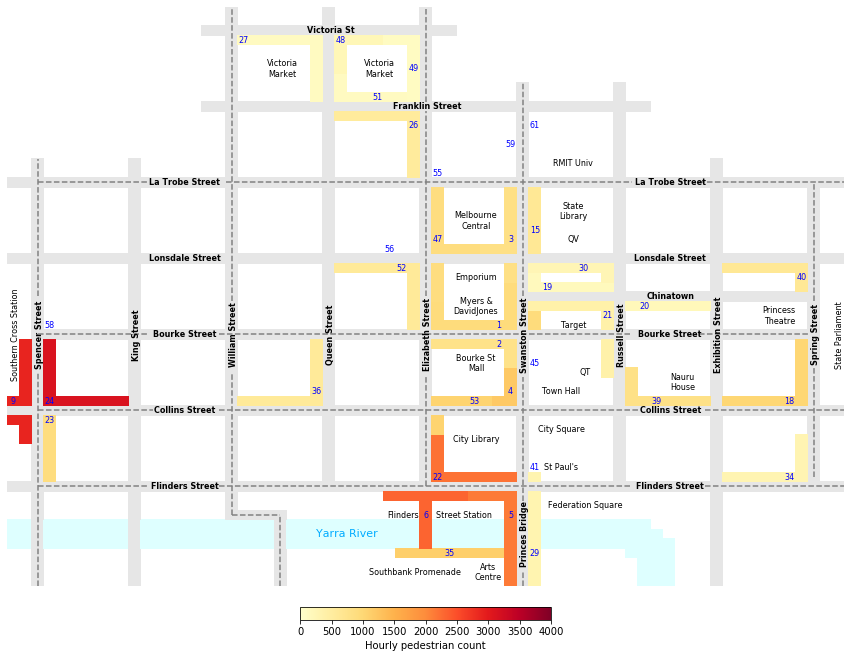

In [79]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Select one point in time
time = pd.to_datetime('2019082609', format='%Y%m%d%H', errors='ignore')

# Select one sensor location
sensor = 1

# Populate np array with signal data for plotting
dfsignal = dfmodel.loc[time]
signal_data = np.empty((61, 69))
signal_data[:] = np.nan
for i in range(len(dfsignal)):
    x, y, predict = dfsignal.iloc[i].x, dfsignal.iloc[i].y, dfsignal.iloc[i].test ## TEMPORARY: TO CHG TO PREDICT
    signal_data[y][x] = predict

# Plot base map
fig, ax = plt.subplots(figsize=(15,13))
road_colors = LinearSegmentedColormap.from_list('road_colors',['#deffff','#e6e6e6'], N=2)
base_map   = ax.pcolor(base_data, cmap=road_colors)

# Plot signal map
signal_map = ax.pcolor(signal_data, cmap='YlOrRd', vmin=0, vmax=4000)

# Plot roads
for label in road_labels:
    plt.text(label[0]+0.65, label[1]+0.5, label[3], rotation=label[2],
             ha='center', va='center', fontsize=8, weight='bold')
# Plot areas
for label in area_labels:
    plt.text(label[0]+0.65, label[1]+0.5, label[3], rotation=label[2],
             ha='center', va='center', fontsize=8)
# Plot sensors
sensor_source = sensor_location[sensor_location['Sensor_img']==1]
for s in range(len(sensor_source)):
        plt.text(sensor_source.iloc[s].x+0.5, sensor_source.iloc[s].y+0.5, sensor_source.index[s],
                 ha='center', va='center', fontsize=8, c='b')
# Plot river name
plt.text(28, 5.5, 'Yarra River', ha='center', va='center', fontsize=11, c='#00acff')

# Plot tram lines
for lines in tram_lines_v:
    plt.vlines(lines[0], lines[1], lines[2], ls='dashed', color='grey')
for lines in tram_lines_h:
    plt.hlines(lines[0], lines[1], lines[2], ls='dashed', color='grey')
    
# Legend
fig.colorbar(signal_map, orientation='horizontal', pad=0.03, shrink=0.3, label='Hourly pedestrian count')
ax.axis('off');

# To do list

~~**EDA**~~
1. ~~Narrow down sites and period~~
2. ~~Variation by high/low traffic sites~~
3. ~~Variation by hour / day of week / seasons~~

~~**Cleansing**~~
1. ~~Verify no missing timestamp~~
2. ~~Fill nulls based on general variation rule~~

~~**Assign sites to groups**~~
1. ~~Run PCA to get better insight on possible groupings~~
2. ~~Combine PCA with EDA info to decide on groupings~~
3. ~~Drop more sites if needed / restate outliers if needed~~

~~**Model approach 1: LSTM**~~
1. ~~Train/test split~~
2. ~~Set up a working LSTM network~~
3. ~~Run baseline Group 1~~
4. ~~Predict at total level~~
6. ~~Redo the start/end date to match SARIMA dates~~
7. ~~Fix moving input prediction calculation method~~
8. ~~Hyperparameters grid search & n_steps~~

**Model approach 2: SARIMA**
1. ~~Train/test split~~
2. ~~Stationarity~~
3. ~~Differencing~~
4. ~~PACF, ACF~~
5. ~~Select p, d, q~~
6. ~~Select P, D, Q, m seasonality~~
7. ~~Hyperparameters grid search~~
8. ~~Predict at total level~~
9. ~~Predict at individual site level~~
10. ~~Difference using minmax vs standard scaler~~
11. ~~Any way to fix standard scaler at site level?~~
12. ~~Compare result for longer training period~~
13. ~~Evaluate individual sites error for Group 1~~
14. ~~General model per group vs customize models - decided on individual models~~
15. ~~Run model with 7 day cycle~~
16. **Hyperparameters for Group 2 & 3**
17. **Train all sites individually using Group parameters**

**Visualisation for end users**
1. Static heatmap on city centre map
2. Variable heatmap animation
3. Variable hourly plot animation
4. Web app
